In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
%cd drive/MyDrive/Colab Notebooks/disaster_tweets

/content/drive/MyDrive/Colab Notebooks/disaster_tweets


## <b> Upgrade BERT model </b>

In [38]:
random_state_split = 42
Dropout_num = 0
learning_rate = 5.95e-6
valid = 0.15
epochs_num = 3
batch_size_num = 8
target_corrected = False
target_big_corrected = False

## <b> 1. Import Libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## <b> 2. Download Data 

In [7]:
tweet = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [8]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [9]:
tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


# <b> 3. EDA </b>

Thanks to:
* https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert/

<b> Class Distribution </b>

Before we begin with anything else, let's check the class distribution.

In [10]:
# extracting the number of examples of each class
Real_len = tweet[tweet['target'] == 1].shape[0]
Not_len = tweet[tweet['target'] == 0].shape[0]

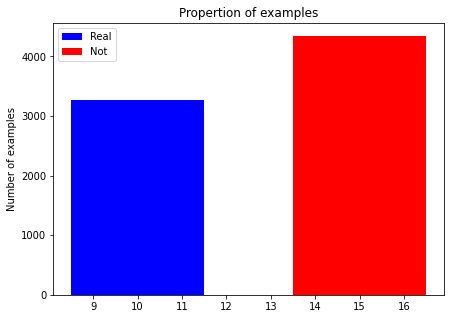

In [11]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10, Real_len, 3, label="Real", color='blue')
plt.bar(15, Not_len, 3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

<b> Number of characters in tweets </b>


In [12]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

In [13]:
tweet['length'] = tweet['text'].apply(length)

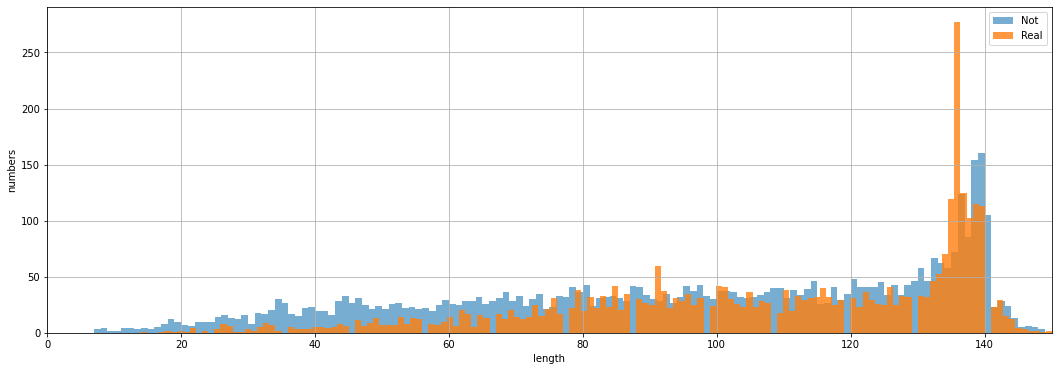

In [14]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweet[tweet['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

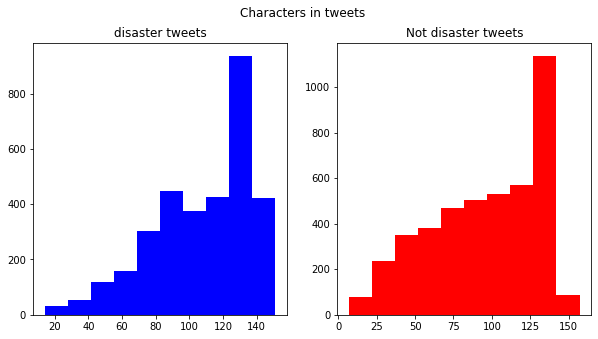

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

The distribution of both seems to be almost same 120 to 140 characters in a tweet are the most common among both.

<b> Number of words in a tweet </b>


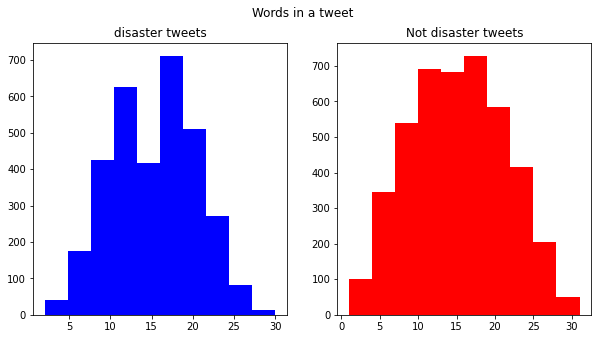

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

<b> Average word length in a tweet </b>


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

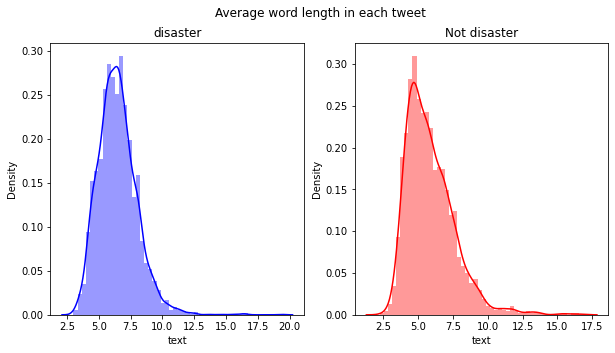

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1, color='blue')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2, color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

## <b> Bert Using TFHub </b>

In [18]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [19]:
pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 13.0 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 213 kB 44.7 MB/s 
     |████████████████████████████████| 1.2 MB 36.6 MB/s 
     |████████████████████████████████| 47.6 MB 40 kB/s 
     |████████████████████████████████| 352 kB 48.6 MB/s 
     |████████████████████████████████| 99 kB 9.5 MB/s 
     |████████████████████████████████| 1.1 MB 46.4 MB/s 


In [20]:
pip install -q -U tensorflow-text

     |████████████████████████████████| 4.4 MB 12.7 MB/s 


In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [22]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [23]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if Dropout_num == 0:
        # Without Dropout
        out = Dense(1, activation='sigmoid')(clf_output)
    else:
        # With Dropout(Dropout_num), Dropout_num > 0
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## <b> Big target correction </b>

In [24]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert

def clean_tweets(tweet):
    """Removes links and non-ASCII characters"""
    
    tweet = ''.join([x for x in tweet if x in string.printable])
    
    # Removing URLs
    tweet = re.sub(r"http\S+", "", tweet)
    
    return tweet

In [25]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [26]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    
    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text

In [27]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [28]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
# 단어 단위의 abbrev를 원래 형태로 변환
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [29]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
# text 단위를 token화하여 convert_abbrev를 이용해 abbrev를 원래 의미의 단어 및 어구로 변환
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

## <b> Download data </b>

In [30]:
# Load BERT from the Tensorflow Hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [31]:
# Load CSV files containing training data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## <b> Target Correction </b>

In [32]:
# Thanks to https://www.kaggle.com/wrrosa/keras-bert-using-tfhub-modified-train-data - 
# author of this kernel read tweets in training data and figure out that some of them have errors:
if target_corrected:
    ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
    train.loc[train['id'].isin(ids_with_target_error),'target'] = 0
    train[train['id'].isin(ids_with_target_error)]

In [33]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
if target_big_corrected:
    train["text"] = train["text"].apply(lambda x: clean_tweets(x))
    test["text"] = test["text"].apply(lambda x: clean_tweets(x))
    
    train["text"] = train["text"].apply(lambda x: remove_emoji(x))
    test["text"] = test["text"].apply(lambda x: remove_emoji(x))
    
    train["text"] = train["text"].apply(lambda x: remove_punctuations(x))
    test["text"] = test["text"].apply(lambda x: remove_punctuations(x))
    
    train["text"] = train["text"].apply(lambda x: convert_abbrev_in_text(x))
    test["text"] = test["text"].apply(lambda x: convert_abbrev_in_text(x))

## <b> Build and train BERT model </b>


In [34]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.tokenization.FullTokenizer(vocab_file, do_lower_case)

In [35]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Encode the text into tokens, masks, and segment flags
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [36]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Build BERT model with my tuning
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [39]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Train BERT model with my tuning
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = valid,
    epochs = epochs_num, # recomended 3-5 epochs
    callbacks=[checkpoint],
    batch_size = batch_size_num
)

Epoch 1/3
809/809 [==============================] - 1437s 2s/step - loss: 0.4177 - accuracy: 0.8227 - val_loss: 0.3880 - val_accuracy: 0.8424
Epoch 2/3
809/809 [==============================] - 1433s 2s/step - loss: 0.2773 - accuracy: 0.8945 - val_loss: 0.4127 - val_accuracy: 0.8398
Epoch 3/3
809/809 [==============================] - 1433s 2s/step - loss: 0.1453 - accuracy: 0.9456 - val_loss: 0.5099 - val_accuracy: 0.8424


## <b> Prediction </b>

In [40]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Prediction by BERT model with my tuning
model_BERT.load_weights('model_BERT.h5')
test_pred_BERT = model_BERT.predict(test_input)
test_pred_BERT_int = test_pred_BERT.round().astype('int')

In [41]:
# Prediction by BERT model with my tuning for the training data - for the Confusion Matrix
train_pred_BERT = model_BERT.predict(train_input)
train_pred_BERT_int = train_pred_BERT.round().astype('int')

KeyboardInterrupt: ignored

## <b> Submission </b>

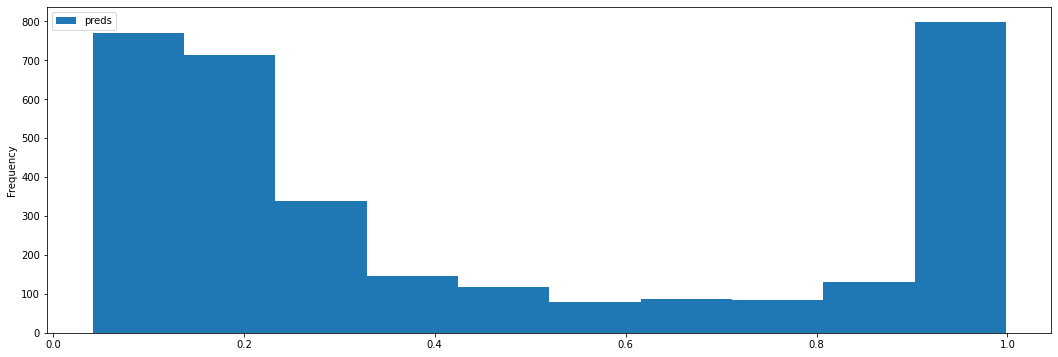

In [42]:
pred = pd.DataFrame(test_pred_BERT, columns=['preds'])
pred.plot.hist()

In [43]:
submission['target'] = test_pred_BERT_int
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [45]:
submission.to_csv("submission_BERT.csv", index=False, header=True)